# A Deep Neural Network Regressor - Rework for TBME

I am using a ConvNet to regress 32 electrode readings into the expected lung volume measurement. Inputs are 32x224 matrices, corresponding to 32 electrodes, with 224 patterns. 

I also include occlusions and elevations as targets. 

In [1]:
%matplotlib inline

#Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
!ls data8

README.docx  test.csv  train.csv  trainElev.csv  trainOccl.csv


In [3]:
# Load Others
def load_data(path,test=False):
    if not test:
        dfile = path + '/train.csv'
        ofile = path + '/trainOccl.csv'
        efile = path + '/trainElev.csv'

        data   = pd.read_csv(dfile,header=None).values
        x_data = data[:,:-1].reshape((-1,32,224,1))
        y_data = data[:, -1]

        o_data = pd.read_csv(ofile,header=None).values
        e_data = pd.read_csv(efile,header=None).values
        return x_data,y_data,o_data,e_data
    
    else:
        tfile = path + '/test.csv'
        data   = pd.read_csv(tfile,header=None).values
        x_data = data[:,:-1].reshape((-1,32,224,1))
        y_data = data[:, -1]
        return x_data,y_data

In [4]:
# Load Data
path  = 'data8'
x_data,y_data,o_data,e_data=load_data(path)

In [5]:
# Scale Data
ysclr  = MinMaxScaler(feature_range=(0,1)).fit(y_data.reshape(-1,1))
y_data = ysclr.transform(y_data.reshape(-1,1)).squeeze()
o_data = o_data/100.
e_data = e_data.squeeze()

In [6]:
x_train,x_valid,\
y_train,y_valid,\
o_train,o_valid,\
e_train,e_valid = train_test_split(x_data,
                                   y_data,
                                   o_data,
                                   e_data,
                                   test_size=0.30,random_state=32)

## Regressor Model

In [7]:
# Keras Imports
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, AveragePooling2D, UpSampling2D
from keras.layers import Flatten, Reshape,Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import PReLU
from keras import regularizers
from keras import backend as K
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
from keras.callbacks import TensorBoard

/home/junior/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
## Training Params
num_batch = 16
num_epoch = 30
patience  = 10

# Parameters
# ndim = x_train.shape[1]
npat,ndim,_ = x_train.shape[1:]
L1   = 127
L2   = 169
L3   = 16

In [9]:
# # Build DNN
# def build_model():
#     x = Input(shape=(npat,ndim,1),name='Input')
#     h = Conv2D(28,activation='relu',kernel_size=(3,5),strides=(2,3),padding='same',name='L1')(x)
#     h = BatchNormalization()(h)
#     h = Conv2D(16,activation='relu',kernel_size=(3,3),strides=(2,3),padding='same',name='L2')(h)
#     h = BatchNormalization()(h)
#     h = Conv2D(15,activation='relu',kernel_size=(3,3),strides=(1,3),padding='same',name='L3')(h)
#     h = BatchNormalization()(h)
#     h = AveragePooling2D((2,2),strides=(2,2))(h)
#     h = Flatten()(h)
    
    
#     # Lung Volume
#     y = Dense(7,activation='linear',name='L4')(h)
#     y = Dense(1,activation='linear',name='YOutput')(y)
#     ymodel = Model(x,y)
    
#     # Occlusion
#     o = Dense(10,activation='linear',name='O4')(h)
#     o = Dense(32,activation='relu',name='OOutput')(o)
    
#     # Elevation
#     e = Dense(5,activation='linear',name='E4')(h)
#     e = Dense(1, activation='linear',name='EOutput')(e)
#     cmodel = Model(inputs=[x],outputs=[y,o,e])
    
#     return ymodel, cmodel

In [10]:
# Build DNN
def build_model():
    x = Input(shape=(npat,ndim,1),name='Input')
    h = Conv2D(28,activation='relu',kernel_size=(3,5),strides=(2,3),padding='same',name='L1')(x)
    h = BatchNormalization()(h)
    h = Conv2D(16,activation='relu',kernel_size=(3,3),strides=(2,3),padding='same',name='L2')(h)
    h = BatchNormalization()(h)
    h = Conv2D(15,activation='relu',kernel_size=(3,3),strides=(1,3),padding='same',name='L3')(h)
    h = BatchNormalization()(h)
    h = AveragePooling2D((2,2),strides=(2,2))(h)
    h = Flatten()(h)
    h = Dense(7,activation='linear',name='L4')(h)
    y = Dense(1,activation='linear',name='Output')(h)
    model = Model(x,y)
    return model

In [11]:
# # Compile Model
# model,cmodel = build_model()
# model.compile(optimizer='adam',loss='mean_squared_error')
# cmodel.compile(optimizer='adam', 
#                loss=['mean_squared_error','categorical_crossentropy','mean_squared_error'],
#                loss_weights=[0.7,0.15,0.15])
# model.summary()

In [12]:
# Compile Model
model = build_model()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 224, 1)        0         
_________________________________________________________________
L1 (Conv2D)                  (None, 16, 75, 28)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 75, 28)        112       
_________________________________________________________________
L2 (Conv2D)                  (None, 8, 25, 16)         4048      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 25, 16)         64        
_________________________________________________________________
L3 (Conv2D)                  (None, 8, 9, 15)          2175      
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 9, 15)          60        
__________

In [13]:
# Train
# log = cmodel.fit(x_train, [y_train,o_train,e_train],
#                 batch_size=num_batch,
#                 epochs=num_epoch,
#                 shuffle=True,
#                 validation_data=(x_valid,[y_valid,o_valid,e_valid]))


log = model.fit(x_train, y_train,
                batch_size=num_batch,
                epochs=num_epoch,
                shuffle=True,
                validation_data=(x_valid,y_valid))

Train on 53900 samples, validate on 23100 samples
Epoch 1/30
53900/53900 [==============================] - 27s 493us/step - loss: 0.0892 - val_loss: 0.0283
Epoch 2/30
53900/53900 [==============================] - 17s 315us/step - loss: 0.0224 - val_loss: 0.0163
Epoch 3/30
53900/53900 [==============================] - 18s 335us/step - loss: 0.0124 - val_loss: 0.0095
Epoch 4/30
53900/53900 [==============================] - 17s 312us/step - loss: 0.0087 - val_loss: 0.0069
Epoch 5/30
53900/53900 [==============================] - 17s 310us/step - loss: 0.0068 - val_loss: 0.0063
Epoch 6/30
53900/53900 [==============================] - 17s 320us/step - loss: 0.0057 - val_loss: 0.0045
Epoch 7/30
53900/53900 [==============================] - 16s 297us/step - loss: 0.0048 - val_loss: 0.0039
Epoch 8/30
53900/53900 [==============================] - 16s 302us/step - loss: 0.0044 - val_loss: 0.0041
Epoch 9/30
53900/53900 [==============================] - 17s 306us/step - loss: 0.0040 - val_

In [14]:
# # Compile Model
# model = build_model(cnn=True)
# model.summary()
# model.compile(optimizer='adam',loss='mean_squared_error')

# modelname  = 'hypermodel.h5'
# e_stopper  = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
# checkpoint = ModelCheckpoint(modelname,monitor='val_loss',verbose=1,save_best_only=True)

In [15]:
# # Train Model
# log = model.fit(x_train, y_train,
#               batch_size=num_batch,
#               epochs=num_epoch,
#               shuffle=True,
#               callbacks=[e_stopper,checkpoint],
#               validation_data=(x_valid,y_valid))

In [16]:
# # model.save('model{}.h5'.format(dataid))
# model = load_model(modelname)

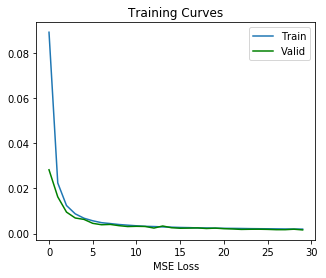

In [17]:
# Training Curves
plt.figure(figsize=(5,4))
plt.plot(log.epoch,log.history['loss'])
plt.plot(log.epoch,log.history['val_loss'],'g')
plt.title('Training Curves')
# plt.ylim([0,0.05])
plt.xlabel('Epochs')
plt.xlabel('MSE Loss')
plt.legend(['Train','Valid'])

In [18]:
# Generate Predictions for Test Set
x_test,y_test = load_data(path,test=True)
y_test = ysclr.transform(y_test.reshape(-1,1)).squeeze()
y_predict = model.predict(x_test)
loss = model.evaluate(x_test,y_test,verbose=0)

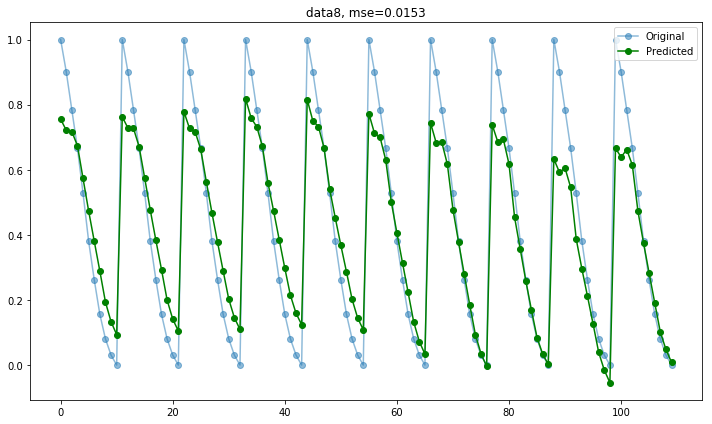

In [19]:
# Plot Results
plt.figure(figsize=(10,6))
# y_tst = scaler.inverse_transform(y_test.squeeze())
# y_prd = scaler.inverse_transform(y_predict.squeeze())
plt.subplot(111)
plt.plot(y_test,'o-',alpha=0.5)
plt.plot(y_predict,'go-')
header = '{0}, mse={1:.04f}'.format(path,loss)
plt.title(header)

# oname = 'data{}/ypred.csv'.format(dataid)
# tname = 'data{}/ytest.csv'.format(dataid)
# np.savetxt(oname,y_predict,delimiter=',')
# np.savetxt(tname,y_test,delimiter=',')

plt.legend(['Original','Predicted'],loc=1)
plt.tight_layout()

----